In [1]:
import MySQLdb as mdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import matplotlib.dates as mdates
import statsmodels.api as sm

In [2]:
#从database获取数据
db_host = 'localhost'
db_user = 'root'
f = open('/Users/chocolatekuma/Documents/MySQL_pw.txt','r')
db_pass = f.read()
db_name = 'test'
con = mdb.connect(db_host,db_user,db_pass,db_name, use_unicode = True, charset='utf8')

sql = """select symbol_id, price_date, close_price from daily_price where price_date between '2013-01-07' and '2018-08-01';"""
df = pd.read_sql_query(sql, con=con)

with con:
    cur = con.cursor()
    cur.execute('select id,ticker,name from symbol')
    symbol = cur.fetchall()
    name = dict(zip([d[0] for d in symbol],[d[2] for d in symbol]))
    ticker = dict(zip([d[0] for d in symbol],[d[1] for d in symbol]))

/anaconda3/envs/tf-session/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: context interface will be changed.  Use explicit conn.commit() or conn.rollback().
  if sys.path[0] == '':


In [3]:
df.head()


,symbol_id,price_date,close_price
0,1,2018-08-01,9.91
1,1,2018-07-31,10.17
2,1,2018-07-30,10.13
3,1,2018-07-27,9.99
4,1,2018-07-26,9.96


In [4]:
df.set_index('price_date', inplace=True)

In [5]:
#获取2013年已经上市的股票
new_symbol = []
for i in range(1,301):
    if len(df[df['symbol_id']==i]) == 1356:
        new_symbol.append(i)
len(new_symbol)    

263

In [6]:
#找到所有有协整关系的股票
coint = {}
for i in new_symbol:
    co = []
    stock1 = df[df['symbol_id'] == i]['close_price']
    print(i, len(stock1))
    for j in new_symbol[new_symbol.index(i)+1:]:
        stock2 = df[df['symbol_id'] == j]['close_price']
        result = ts.coint(stock1,stock2)
        if result[1] <= 0.01:
             co.append(name[j])

1 1356
2 1356
3 1356
4 1356
5 1356
6 1356
7 1356
8 1356
9 1356
10 1356
12 1356
13 1356
14 1356
15 1356
16 1356
17 1356
18 1356
19 1356
20 1356
21 1356
22 1356
23 1356
24 1356
25 1356
26 1356
27 1356
28 1356
29 1356
30 1356
31 1356
32 1356
33 1356
34 1356
35 1356
36 1356
37 1356
38 1356
39 1356
40 1356
41 1356
42 1356
43 1356
44 1356
45 1356
46 1356
47 1356
48 1356
49 1356
50 1356
51 1356
52 1356
53 1356
54 1356
55 1356
56 1356
57 1356
58 1356
59 1356
60 1356
61 1356
62 1356
63 1356
64 1356
65 1356
66 1356
67 1356
68 1356
69 1356
70 1356
71 1356
72 1356
73 1356
74 1356
75 1356
76 1356
77 1356
78 1356
79 1356
80 1356
81 1356
82 1356
83 1356
84 1356
85 1356
86 1356
87 1356
88 1356
89 1356
90 1356
91 1356
92 1356
93 1356
94 1356
95 1356
96 1356
97 1356
98 1356
99 1356
106 1356
107 1356
108 1356
109 1356
110 1356
112 1356
113 1356
114 1356
115 1356
116 1356
119 1356
120 1356
121 1356
125 1356
129 1356
130 1356
131 1356
132 1356
133 1356
135 1356
136 1356
137 1356
138 1356
139 1356
140 1356


In [7]:
coint

{}

In [8]:
#statmodel里面的协整检验的前提假设是两个时序数据是平稳的
#所以找到股价为平稳序列的股票
mean_rev_1 = []
random_walk = []
for i in new_symbol:
    stock = df[df['symbol_id'] == i]['close_price']
    result = ts.adfuller(stock)  
    if result[0]>result[4]['1%'] :
        random_walk.append(name[i])
    else:
        print('The close price of stock: %s is mean-reverting at 1 percent significance level' % name[i])
        mean_rev_1.append(name[i])

The close price of stock: 浦发银行 is mean-reverting at 1 percent significance level
The close price of stock: 国投资本 is mean-reverting at 1 percent significance level
The close price of stock: 宇通客车 is mean-reverting at 1 percent significance level
The close price of stock: 特变电工 is mean-reverting at 1 percent significance level
The close price of stock: 永泰能源 is mean-reverting at 1 percent significance level
The close price of stock: 新湖中宝 is mean-reverting at 1 percent significance level
The close price of stock: 圆通速递 is mean-reverting at 1 percent significance level
The close price of stock: 航天信息 is mean-reverting at 1 percent significance level
The close price of stock: 广汇汽车 is mean-reverting at 1 percent significance level
The close price of stock: 万华化学 is mean-reverting at 1 percent significance level
The close price of stock: 白云山 is mean-reverting at 1 percent significance level
The close price of stock: 华夏幸福 is mean-reverting at 1 percent significance level
The close price of stock: 五矿资

In [9]:
#有协整关系的两支股票有两种情况，一种是两支股票同为平稳序列，一种是两支股票同为不平稳序列
#剔除通过的协整检验，但是一支为平稳序列，一支为不平稳序列的股票配对
for i in coint:
    print(i)
    if i in mean_rev:
        for j in coint[i]:
            if j not in mean_rev:
                coint[i].remove(j)
    else:
        for j in coint[i]:
            if j in mean_rev:
                coint[i].remove(j)

In [10]:
#从有协整关系的股票配对中随意找出一对，看一下它们之间的量化关系
# '万科A': ['顺丰控股']
df['name'] = df['symbol_id'].apply(lambda v: name[v])
df['ticker'] = df['symbol_id'].apply(lambda v: ticker[v])
df.head()

,symbol_id,close_price,name,ticker
price_date,,,,
2018-08-01,1,9.91,浦发银行,600000
2018-07-31,1,10.17,浦发银行,600000
2018-07-30,1,10.13,浦发银行,600000
2018-07-27,1,9.99,浦发银行,600000
2018-07-26,1,9.96,浦发银行,600000


In [11]:
stock1 = df[df['name'] == '万科A']
stock2 = df[df['name'] == '顺丰控股']

In [12]:
stock1.head()

,symbol_id,close_price,name,ticker
price_date,,,,
2018-08-01,184,22.35,万科A,000002
2018-07-31,184,23.32,万科A,000002
2018-07-30,184,23.18,万科A,000002
2018-07-27,184,23.32,万科A,000002
2018-07-26,184,23.71,万科A,000002


In [13]:
s1 = pd.DataFrame(index = stock1.index)
s1['万科A'] = stock1['close_price']
s1['顺丰控股'] = stock2['close_price']

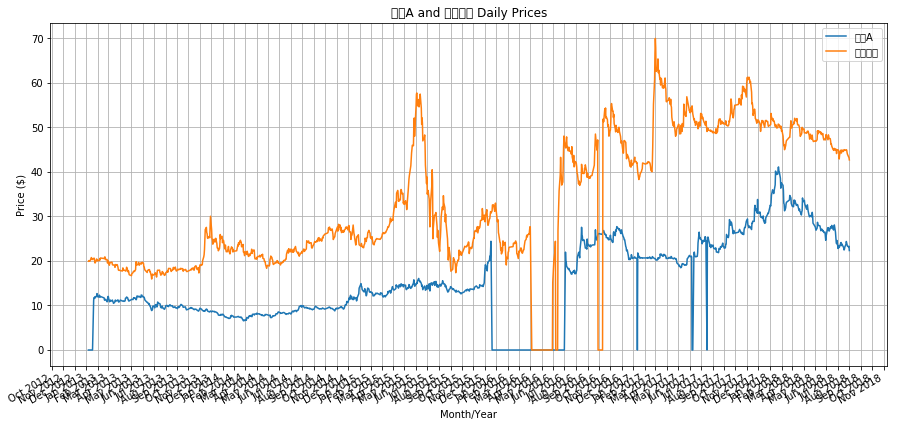

In [14]:
months = mdates.MonthLocator()  # every month
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(s1.index, s1['万科A'], label='万科A')
ax.plot(s1.index, s1['顺丰控股'], label='顺丰控股')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
ax.grid(True)
fig.autofmt_xdate()

plt.xlabel('Month/Year')
plt.ylabel('Price ($)')
plt.title('%s and %s Daily Prices' % ('万科A', '顺丰控股'))
plt.legend()
plt.show()

In [15]:
#剔除未开盘的数据
s1 = s1[s1['顺丰控股'] != 0]
s1 = s1[s1['万科A'] != 0]
len(s1)

1207

In [16]:
#最小二乘法
X = s1['万科A'].values
y = s1['顺丰控股'].values
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     3103.
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:25:25   Log-Likelihood:                -4118.0
No. Observations:                1207   AIC:                             8240.
Df Residuals:                    1205   BIC:                             8250.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7868      0.494     19.802      0.0

Text(0.5,0,'万科A')

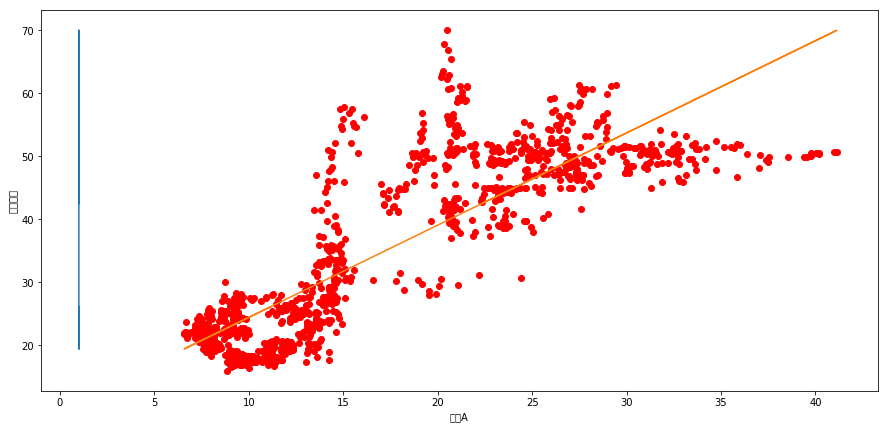

In [17]:
fig,ax=plt.subplots(figsize=(15,7))
ax.plot(X,results.fittedvalues,label='regression line')
ax.scatter(s1['万科A'].values,s1['顺丰控股'].values,label='data point',color='r')
ax.set_ylabel('顺丰控股')
ax.set_xlabel('万科A')

In [18]:
diff =s1['顺丰控股']-1.4641*s1['万科A']

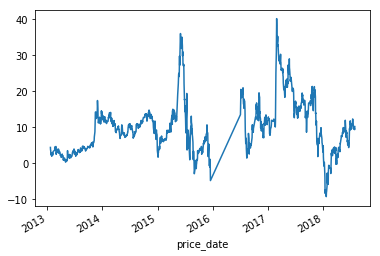

In [19]:
diff.plot()

In [20]:
diff.mean()

9.787459019884011

In [21]:
ts.adfuller(diff)

(-3.9450653725320777,
 0.0017271185214631612,
 11,
 1195,
 {'1%': -3.4358340188169882,
  '10%': -2.5680593310691338,
  '5%': -2.8639616494853217},
 4142.308748622263)

In [22]:
#
z_score = (diff-diff.mean())/diff.std(0)
z_score.head()

price_date
2018-08-01    0.027237
2018-07-31   -0.088599
2018-07-30   -0.044322
2018-07-27    0.008138
2018-07-26   -0.020610
dtype: float64

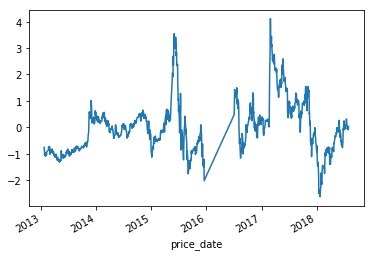

In [23]:

z_score.plot()